# Testing CAPPI data with Py-ART and wradlib

@author: Camila Lopes (camila.lopes@iag.usp.br)

In [1]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader

import pyart
# import wradlib as wrl

from read_sipam_cappis import read_sipam_cappi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
def ppi_to_grid(filename):

    # Read data and convert to grid
    radar = pyart.aux_io.read_gamic(filename)
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(20, 501, 501),
        grid_limits=((1e3, 20e3), (-250e3, 250e3), (-250e3, 250e3))
    )

    return grid

In [ ]:
filename = "../data/radar/sipam_manaus/arm_cappi/2014-05/20140509/sbmn_cappi_20140509_233557.nc"
# wset = wrl.io.read_generic_netcdf(filename)

In [ ]:
plt.imshow(wset['variables']['DBZc']['data'][0, 20, :, :])

In [ ]:
xset = xr.open_dataset(filename)
xset.variables['z0']

In [ ]:
dset = netCDF4.Dataset(filename)
print(dset["start_time"])
print(dset["stop_time"])

In [ ]:
print(dset.variables["lat0"][:][-1,-1] - dset.variables["lat0"][:][-2,-2],
dset.variables["lat0"][:][-3,-3] - dset.variables["lat0"][:][-2,-2],
dset.variables["lat0"][:][-3,-3] - dset.variables["lat0"][:][-4,-4])


In [ ]:
dset.variables['time_bounds']

In [ ]:
grid = ppi_to_grid("../data/radar/sipam_manaus/arm/201401/RADL08061720140103031200.HDF5")

In [6]:
filename = "../data/radar/sipam_manaus/arm_cappi/2014-05/20140509/sbmn_cappi_20140509_114801.nc"

cappi = read_sipam_cappi(filename)

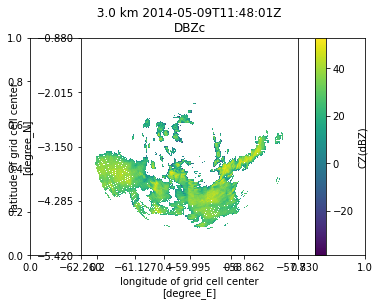

In [7]:
display = pyart.graph.GridMapDisplay(cappi)
display.plot_grid("DBZc", level=5)


In [ ]:
cappi.instrument_parameters

In [ ]:
test = pyart.retrieve.grid_shift(cappi, advection=(0,0), trim_edges=50)
print(test.get_point_longitude_latitude()[0].min(),
        test.get_point_longitude_latitude()[1].min(),
        test.get_point_longitude_latitude()[0].max(),
        test.get_point_longitude_latitude()[1].max())
display = pyart.graph.GridMapDisplay(test)
display.plot_grid("range", level=5, vmin=0, vmax=150)
display.plot_crosshairs()

In [ ]:
print(cappi.get_point_longitude_latitude()[0].min(),
        cappi.get_point_longitude_latitude()[1].min(),
        cappi.get_point_longitude_latitude()[0].max(),
        cappi.get_point_longitude_latitude()[1].max())
display = pyart.graph.GridMapDisplay(cappi)
display.plot_grid("range", level=5, vmin=0, vmax=150)
display.plot_crosshairs()

In [ ]:
radar = wrl.io.hdf.read_generic_hdf5("../data/radar/sipam_manaus/arm/201401/RADL08061720140117013600.HDF5")

In [ ]:
print(radar.keys())

# print(radar['scan0/how']['attrs']['elevation'])
# print(radar['scan1/how']['attrs']['elevation'])
# print(radar['scan2/how']['attrs']['elevation'])
# print(radar['scan3/how']['attrs']['elevation'])
# print(radar['scan4/how']['attrs']['elevation'])
# print(radar['scan5/how']['attrs']['elevation'])
# print(radar['scan6/how']['attrs']['elevation'])
# print(radar['scan7/how']['attrs']['elevation'])
# print(radar['scan8/how']['attrs']['elevation'])
# print(radar['scan9/how']['attrs']['elevation'])
# print(radar['scan10/how']['attrs']['elevation'])
# print(radar['scan11/how']['attrs']['elevation'])
# print(radar['scan12/how']['attrs']['elevation'])

print(radar['where'])

In [ ]:
pyart.util.datetime_from_grid(cappi).strftime('%Y%m%d%H%M%S')

In [ ]:
np.array(np.ma.MaskedArray.tolist(cappi.fields['DBZc']['data']))
# np.nanmax(x[x != None])

In [ ]:
display = pyart.graph.GridMapDisplay(cappi)
projection = ccrs.PlateCarree()
display.plot_grid('DBZc', level=0, projection=projection)

In [ ]:
display.grid.to_xarray()

In [ ]:
raw = pyart.aux_io.read_gamic(
    "../data/radar/sipam_manaus/arm/201401/RADL08061720140103031200.HDF5")

"%.2f" % raw.fixed_angle['data'][0]

In [ ]:
ranges = raw.range['data']
elevs = raw.fixed_angle['data']
site = (float(raw.longitude['data']),
        float(raw.latitude['data']),
        float(raw.altitude['data']))
beamwidth = float(raw.instrument_parameters['radar_beam_width_h']['data'])


ax = wrl.vis.plot_scan_strategy(ranges, elevs, site, beamwidth, vert_res=1000, maxalt=20000, units='km')
ax.set_title('SIPAM S-Band')

In [ ]:
# GoAmazon site locations
sites = pd.read_csv("../data/general/goamazon_sites.csv", sep=";", decimal=",")
sites['Latitude']

In [ ]:
# Range rings + site locations
display = pyart.graph.RadarMapDisplay(raw)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

display.plot_ppi_map("corrected_reflectivity", 0, vmin=0, shapefile="../data/general/shapefiles/lineaire_1km",
    shapefile_kwargs={"facecolor": "None", "edgecolor": "darkblue", "alpha": 0.5, "linewidth": 0.75})
# GoAmazon sites
ax.scatter(sites["Longitude"], sites["Latitude"], s=5, c='red')
ax.annotate(sites["GoAmazon2014/5 reference"][0], xy=(sites["Longitude"][0], sites["Latitude"][0]))
ax.annotate(sites["GoAmazon2014/5 reference"][1], xy=(sites["Longitude"][1], sites["Latitude"][1]))
ax.annotate(sites["GoAmazon2014/5 reference"][2], xy=(sites["Longitude"][2], sites["Latitude"][2]))
ax.annotate(sites["GoAmazon2014/5 reference"][3], xy=(sites["Longitude"][3], sites["Latitude"][3]), horizontalalignment='right')
ax.annotate(sites["GoAmazon2014/5 reference"][4], xy=(sites["Longitude"][4], sites["Latitude"][4]), horizontalalignment='right')
ax.annotate(sites["GoAmazon2014/5 reference"][5], xy=(sites["Longitude"][5], sites["Latitude"][5]))
ax.annotate(sites["GoAmazon2014/5 reference"][6], xy=(sites["Longitude"][6], sites["Latitude"][6]), horizontalalignment='right')
ax.annotate(sites["GoAmazon2014/5 reference"][7], xy=(sites["Longitude"][7], sites["Latitude"][7]))
ax.annotate(sites["GoAmazon2014/5 reference"][8], xy=(sites["Longitude"][8], sites["Latitude"][8]), horizontalalignment='right')
# Adding shapefile
ax.add_geometries(Reader("../data/general/shapefiles/AM_Municipios_2019").geometries(), ccrs.PlateCarree(), linewidth=0.75,
    facecolor="None", edgecolor="darkgray", alpha=0.8)
# Adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=np.arange(-70, -50, 1), ylocs=np.arange(-10, 1, 1), alpha=0.5)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
display.plot_range_rings([50, 100, 150, 200, 250], ax=ax, col="black", lw=1)
plt.savefig("figs/sipam_range_rings.png", dpi=300, bbox_inches="tight")


In [ ]:
# cappi = read_sipam_cappi("../data/radar/sipam_manaus/arm_cappi/2014-09/20140918/sbmn_cappi_20140918_140007.nc")
dset = netCDF4.Dataset("../data/radar/sipam_manaus/arm_cappi/2015-04/20150403/sbmn_cappi_20150403_084807.nc")
# wset = wrl.io.read_generic_netcdf("../data/radar/sipam_manaus/arm_cappi/2015-04/20150403/sbmn_cappi_20150403_084807.nc")

In [ ]:
print(cappi.get_point_longitude_latitude()[0].min(),
        cappi.get_point_longitude_latitude()[1].min(),
        cappi.get_point_longitude_latitude()[0].max(),
        cappi.get_point_longitude_latitude()[1].max())
display = pyart.graph.GridMapDisplay(cappi)
display.plot_grid("DBZc", level=3, vmin=-10, vmax=70, imshow=True)

In [ ]:
subset = slice(45, -45)
test = np.flipud(cappi.fields['DBZc']['data'][5][subset, subset])
plt.imshow(test, vmin=-10, vmax=70)
plt.colorbar()

In [ ]:
print(cappi.get_point_longitude_latitude()[0].shape)

In [ ]:
# print(dset.variables["lat0"][-1,:])
plt.imshow(dset.variables["DBZc"][0][5])

In [ ]:
plt.imshow(wset['variables']['DBZc']['data'][0][5])

In [2]:
# Read CPTEC data
cptec_file = "/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/2015/04/cappi_201504030848.dat"
cptec = np.fromfile(cptec_file, dtype="float32").reshape(15,500,500)
cptec[cptec == -99.] = np.nan

In [ ]:
cptec_date =  datetime.strptime(re.findall(r"\d{12}", cptec_file)[0], "%Y%m%d%H%M%S")

In [ ]:
cptec_date

In [ ]:
# Lat/lon grids
lat_file = "/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/lat_SBMN_500.txt"
lat_grid = np.fromfile(lat_file, sep="   ").reshape(500,500)
lon_file = "/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/lon_SBMN_500.txt"
lon_grid = np.fromfile(lon_file, sep="   ").reshape(500,500)

In [ ]:
dset.variables["time"]

In [7]:
import pyart

from read_sipam_cappis_cptec import read_sipam_cappi

cpfile = read_sipam_cappi("/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/2015/04/cappi_201504030848.dat")

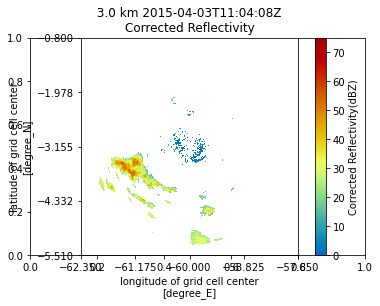

In [8]:
display = pyart.graph.GridMapDisplay(cpfile)
display.plot_grid("corrected_reflectivity", level=1, vmin=0, mask_outside=True)